In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# Menonaktifkan verifikasi sertifikat SSL secara global (hanya untuk tujuan demonstrasi, bukan praktek yang disarankan)
tf.keras.utils.get_file = lambda *args, **kwargs: get_file(*args, **kwargs, ssl_verify=False)

In [2]:
# Definisikan path ke folder dataset
dataset_path = 'dataset'

# Inisialisasi ImageDataGenerator untuk preprocessing gambar
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi data gambar
    rotation_range=20,  # Rentang rotasi gambar
    width_shift_range=0.2,  # Pergeseran lebar gambar
    height_shift_range=0.2,  # Pergeseran tinggi gambar
    shear_range=0.2,  # Pergeseran gambar
    zoom_range=0.2,  # Zoom gambar
    horizontal_flip=True,  # Putar gambar secara horizontal
    fill_mode='nearest'  # Mode pengisian untuk gambar yang diubah
)

# Membuat generator untuk setiap set data (train, validation, test)
train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'valid'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 210 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [3]:
# Membuat model VGG16
base_model = VGG16(weights='imagenet', include_top=False) 

# Mengambil output layer dari model
x = base_model.output

# Menambahkan global average pooling layer
x = GlobalAveragePooling2D()(x)

# Menambahkan fully connected layer dengan 1024 neuron
x = Dense(1024, activation='relu')(x)

# Menambahkan output layer dengan 7 neuron (sesuaikan dengan jumlah kelas Anda)
predictions = Dense(7, activation='softmax')(x)

# Membuat model dengan input dari base model dan output dari layer yang baru ditambahkan
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan semua layer di model VGG16 agar tidak terlatih ulang
for layer in base_model.layers:
    layer.trainable = False

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menambahkan EarlyStopping untuk menghentikan pelatihan jika tidak ada peningkatan dalam validasi loss
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True)

# Menyimpan bobot terbaik selama pelatihan
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')

# Menyimpan log pelatihan ke file CSV
csv_logger = CSVLogger('training_log.csv')

# Mengurangi learning rate jika tidak ada peningkatan dalam validasi loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [4]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=[early_stopping, checkpoint, csv_logger, reduce_lr]
)

# Memuat bobot terbaik untuk evaluasi ResNet101
model.load_weights('best_model.h5')

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 1.9098 - accuracy: 0.2667
Epoch 1: val_loss improved from inf to 1.65232, saving model to best_model.h5
7/7 [==============================] - 85s 12s/step - loss: 1.9098 - accuracy: 0.2667 - val_loss: 1.6523 - val_accuracy: 0.4571 - lr: 0.0010
Epoch 2/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 1.5155 - accuracy: 0.4905
Epoch 2: val_loss improved from 1.65232 to 1.26245, saving model to best_model.h5
7/7 [==============================] - 80s 11s/step - loss: 1.5155 - accuracy: 0.4905 - val_loss: 1.2625 - val_accuracy: 0.8714 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 1.1999 - accuracy: 0.8095
Epoch 3: val_loss improved from 1.26245 to 1.01827, saving model to best_model.h5
7/7 [==============================] - 86s 12s/step - loss: 1.1999 - accuracy: 0.8095 - val_loss: 1.0183 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.9758 - accuracy: 0.8143
Epoch 4: val_loss improved from 1.01827 to 0.78434, saving model to best_model.h5
7/7 [==============================] - 79s 11s/step - loss: 0.9758 - accuracy: 0.8143 - val_loss: 0.7843 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 5/50
7/7 [==============================] - ETA: 0s - loss: 

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prediksi data validasi
valid_predictions = model.predict(valid_generator)
valid_pred_classes = np.argmax(valid_predictions, axis=1)
valid_true_classes = valid_generator.classes

# Menghitung metrik-metrik evaluasi
accuracy = accuracy_score(valid_true_classes, valid_pred_classes)
precision = precision_score(valid_true_classes, valid_pred_classes, average='weighted')
recall = recall_score(valid_true_classes, valid_pred_classes, average='weighted')
f1 = f1_score(valid_true_classes, valid_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


3/3 [==============================] - 13s 3s/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


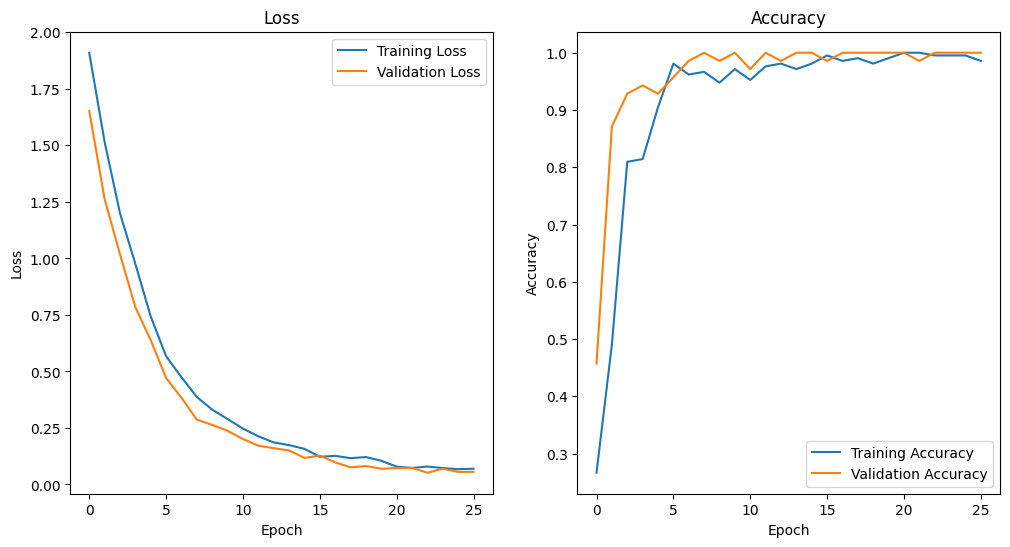

In [6]:
import matplotlib.pyplot as plt

# Membaca log pelatihan dari file CSV
import pandas as pd
log_data = pd.read_csv('training_log.csv')

# Membuat grafik
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(log_data['epoch'], log_data['loss'], label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(log_data['epoch'], log_data['accuracy'], label='Training Accuracy')
plt.plot(log_data['epoch'], log_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [7]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label sebenarnya dari data uji
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Menampilkan laporan klasifikasi
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))


3/3 [==============================] - 13s 3s/step
              precision    recall  f1-score   support

       bujuh       1.00      1.00      1.00        10
       dalem       1.00      1.00      1.00        10
       keras       1.00      1.00      1.00        10
     penasar       1.00      1.00      1.00        10
   sidakarya       1.00      1.00      1.00        10
         tua       1.00      1.00      1.00        10
       wijil       1.00      1.00      1.00        10

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



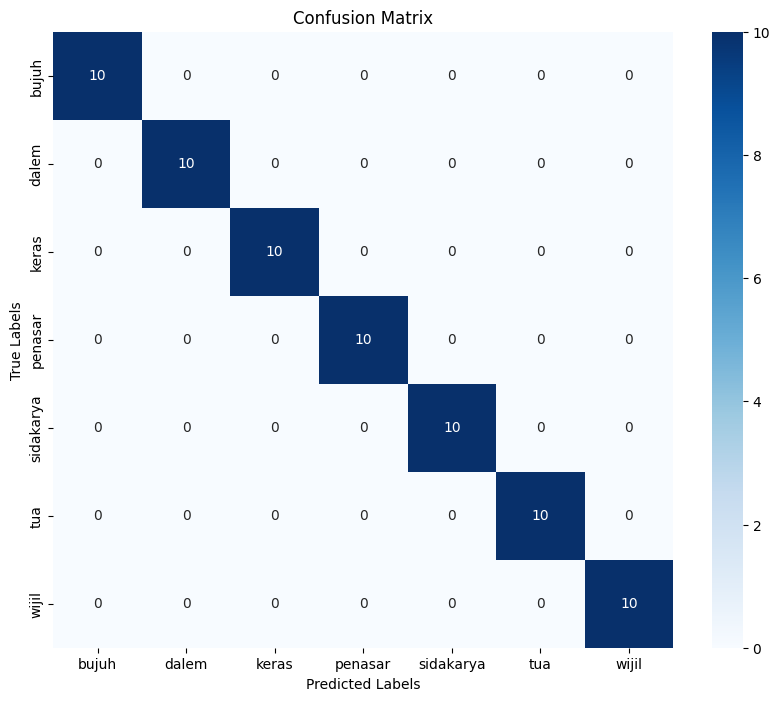

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
